In [9]:
import cv2
from PIL import Image
import clip
import torch
import numpy as np
import math
import pandas
import plotly.express as px
import datetime
from IPython.core.display import HTML
import matplotlib.pyplot as plt

In [11]:
microwave = './examples/micro.mp4'
kettle = './examples/kettle.mp4'
light = './examples/light_switch.mp4'
slide_cabinet = './examples/slide_cabinet.mp4'
hinge_cabinet = './examples/hinge_cabinet.mp4'
bottom_burner = './examples/bottom_burner.mp4'
top_burner = './examples/top_burner.mp4'

block_push = './examples/block.mp4'
carla1 = './examples/carla1.mp4'
carla2 = './examples/carla2.mp4'

In [4]:
# all_tasks = [microwave, kettle, light, slide_cabinet, hinge_cabinet, bottom_burner, top_burner]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [17]:
def ask_task(task_name, prompt, plot=True, show_frames=False, friend_frames=1):
    frames = []
    video_cv2 = cv2.VideoCapture(task_name)
    frame_cv2 = video_cv2.get(cv2.CAP_PROP_FPS)
    current_frame = 0
    while video_cv2.isOpened():
        ret, frame = video_cv2.read()
        if ret == True:
            frames.append(Image.fromarray(frame[:, :, ::-1]))
        else:
            break
        current_frame += 1
        video_cv2.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    
    print(f"Frames extracted: {len(frames)}")

    batch_size = 256
    video_batch = math.ceil(len(frames) / batch_size)
    image_features = torch.empty([0, 512], dtype=torch.float16).to(device)

    for i in range(video_batch):
        print(f"Processing batch {i+1}/{video_batch}")
        frame_batch = frames[i*batch_size : (i+1)*batch_size]
        preprocess_batch = torch.stack([preprocess(frame) for frame in frame_batch]).to(device)
        with torch.no_grad():
            batch_features = model.encode_image(preprocess_batch)
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
        image_features = torch.cat((image_features, batch_features))

    print(f"Features: {image_features.shape}")
    
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(prompt).to(device))
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)
    top_frame, index_frame  = similarity.topk(friend_frames, dim=0)
    if plot:
        fig = px.imshow(similarity.T.cpu().numpy(), height=100, aspect='auto', color_continuous_scale='cividis')
        fig.update_layout(coloraxis_showscale=True)
        fig.update_xaxes(showticklabels=True)
        fig.update_yaxes(showticklabels=True)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        plt.plot(similarity.cpu().numpy())
        print()


    if show_frames:
        for i in index_frame:
            display(frames[i])
            seconds = round(i.cpu().numpy()[0] * 1 / frame_cv2)
            display(HTML(f"{str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" &t={seconds}\">link</a>)"))
    

Frames extracted: 73
Processing batch 1/1
Features: torch.Size([73, 512])


AttributeError: type

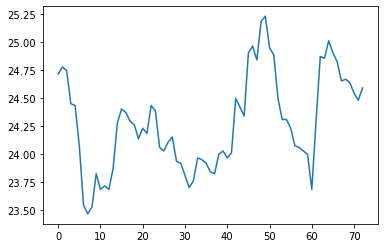

: 

In [19]:
ask_task(task_name=microwave, prompt="open the microwave door", plot=True, show_frames=True, friend_frames=3)

In [ ]:
microwave = 0
kettle = 1
light = 2
slide_cabinet = 3
hinge_cabinet = 4
bottom_burner = 5
top_burner = 6

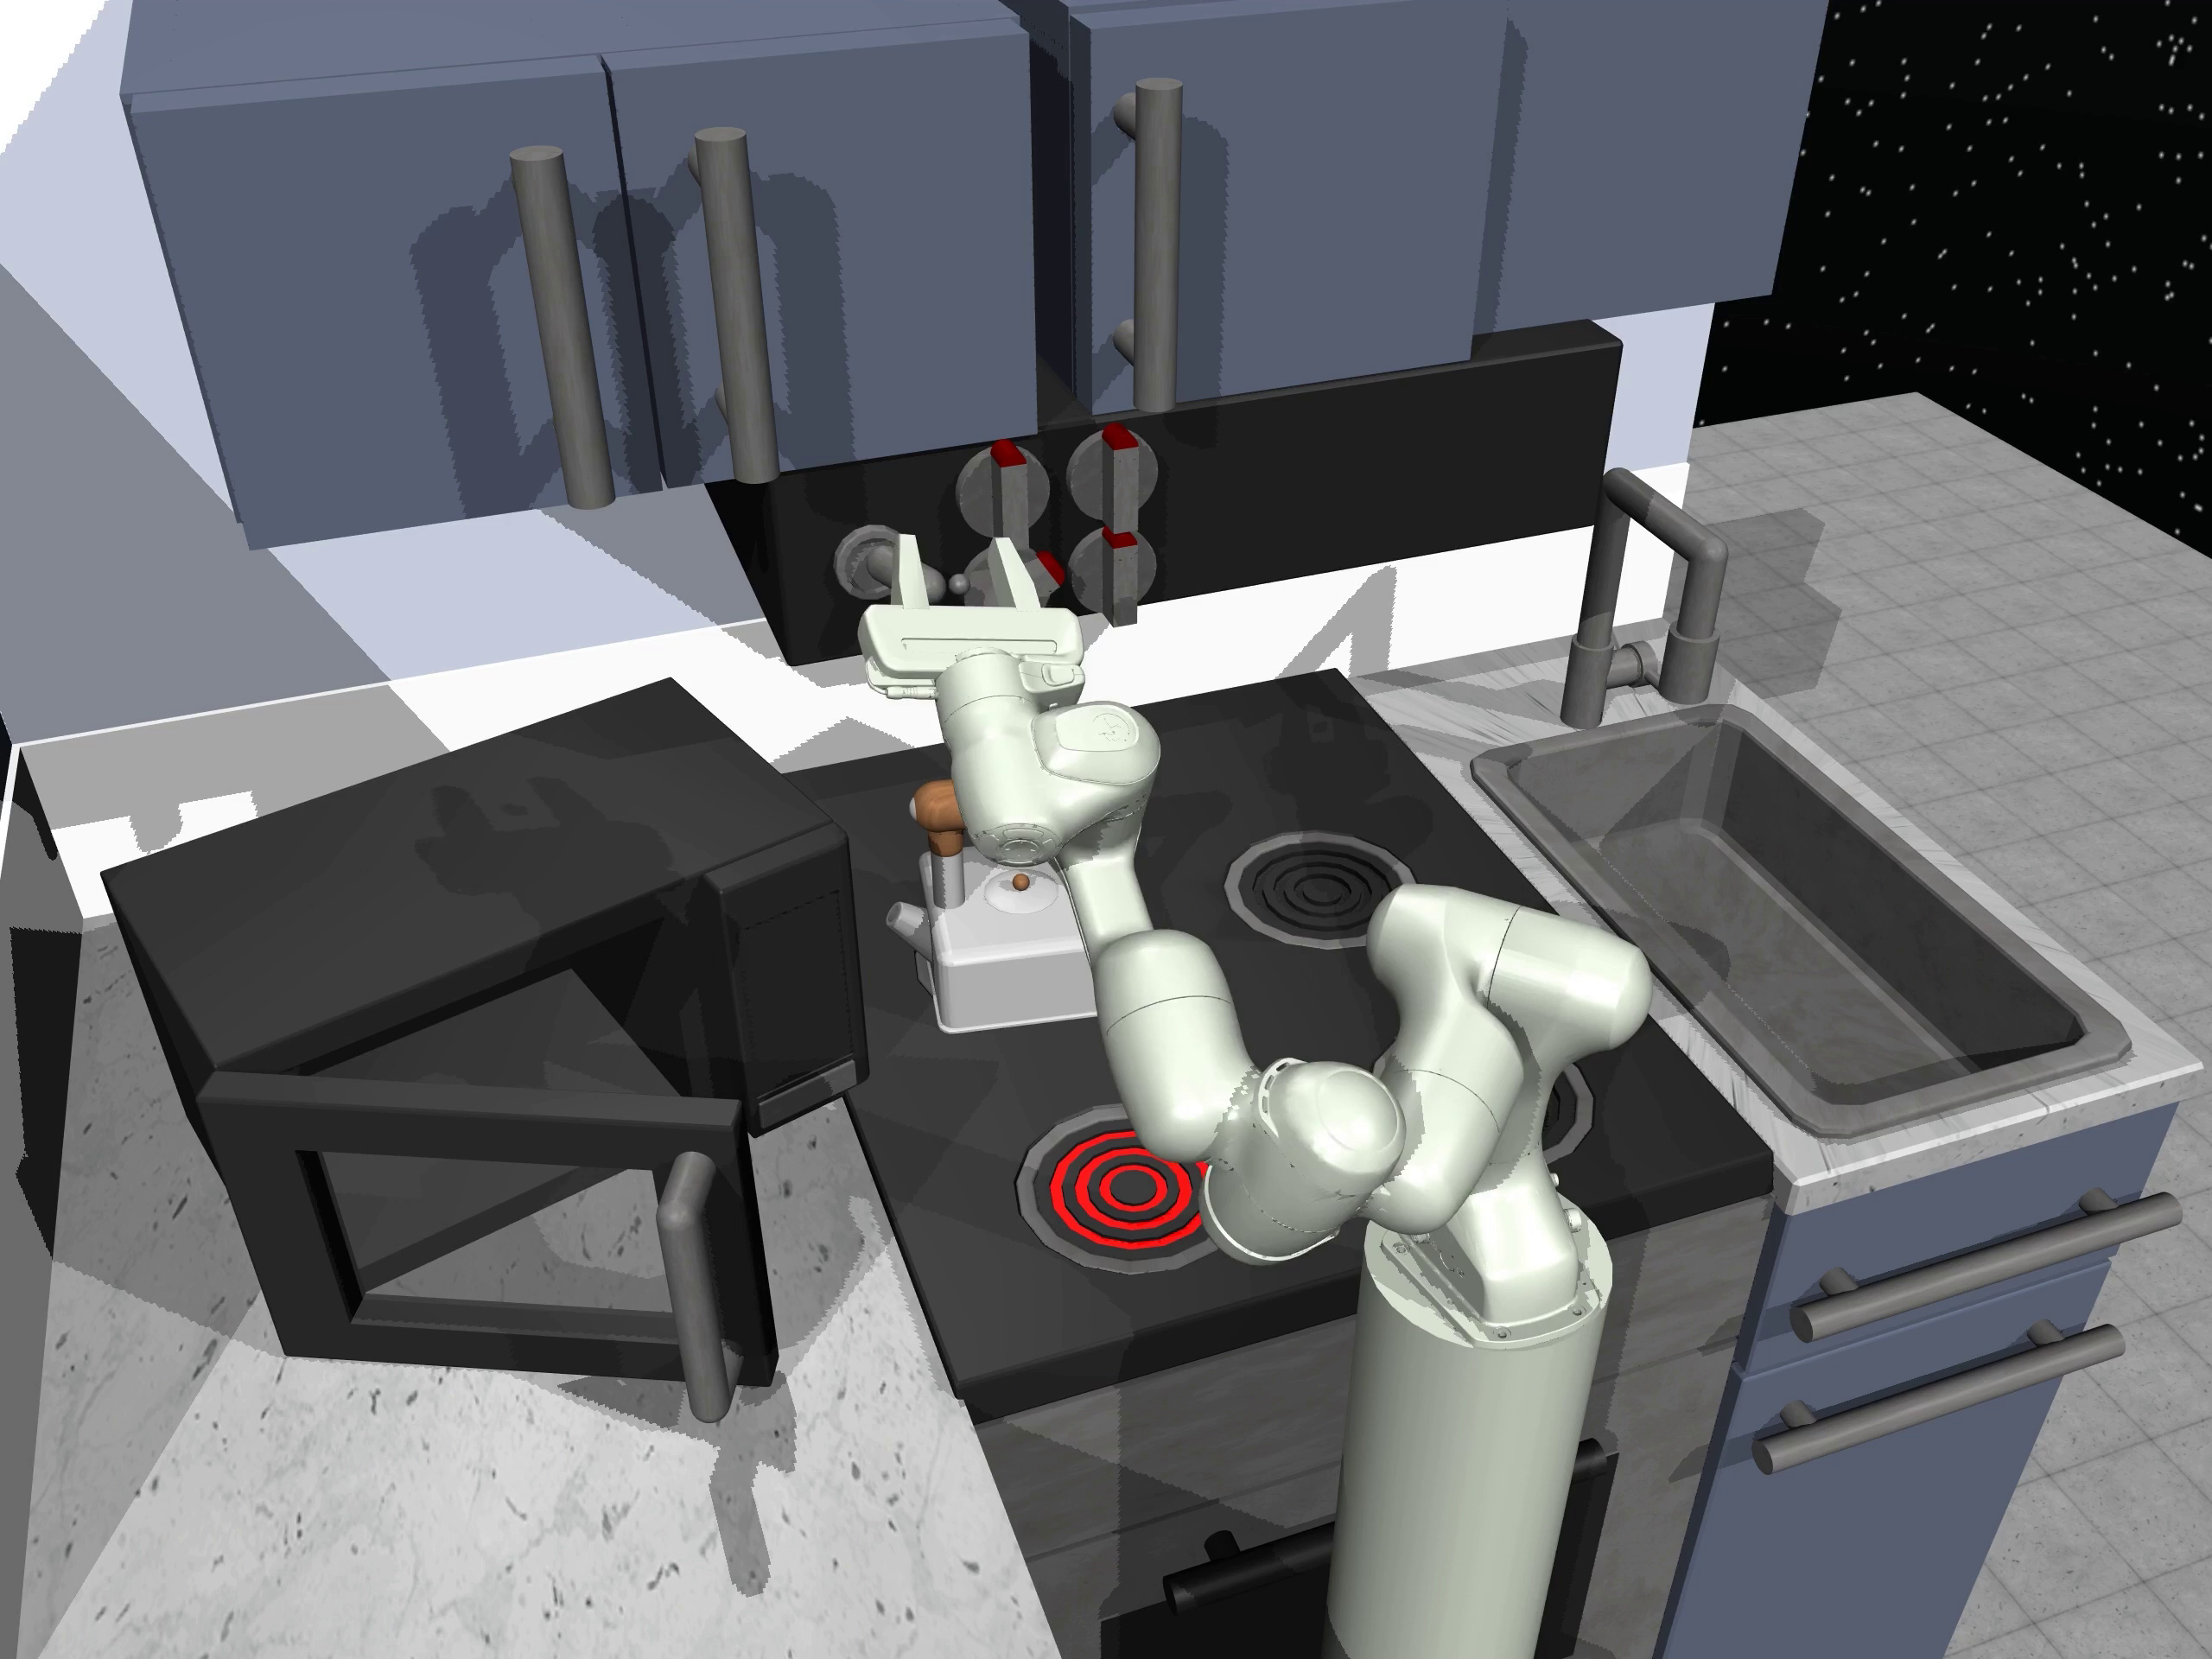

91


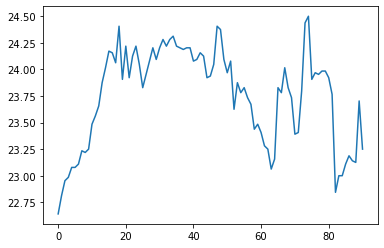

In [130]:
accept_input("push the kettle", task_id=1, plot=True, show_frames=True)

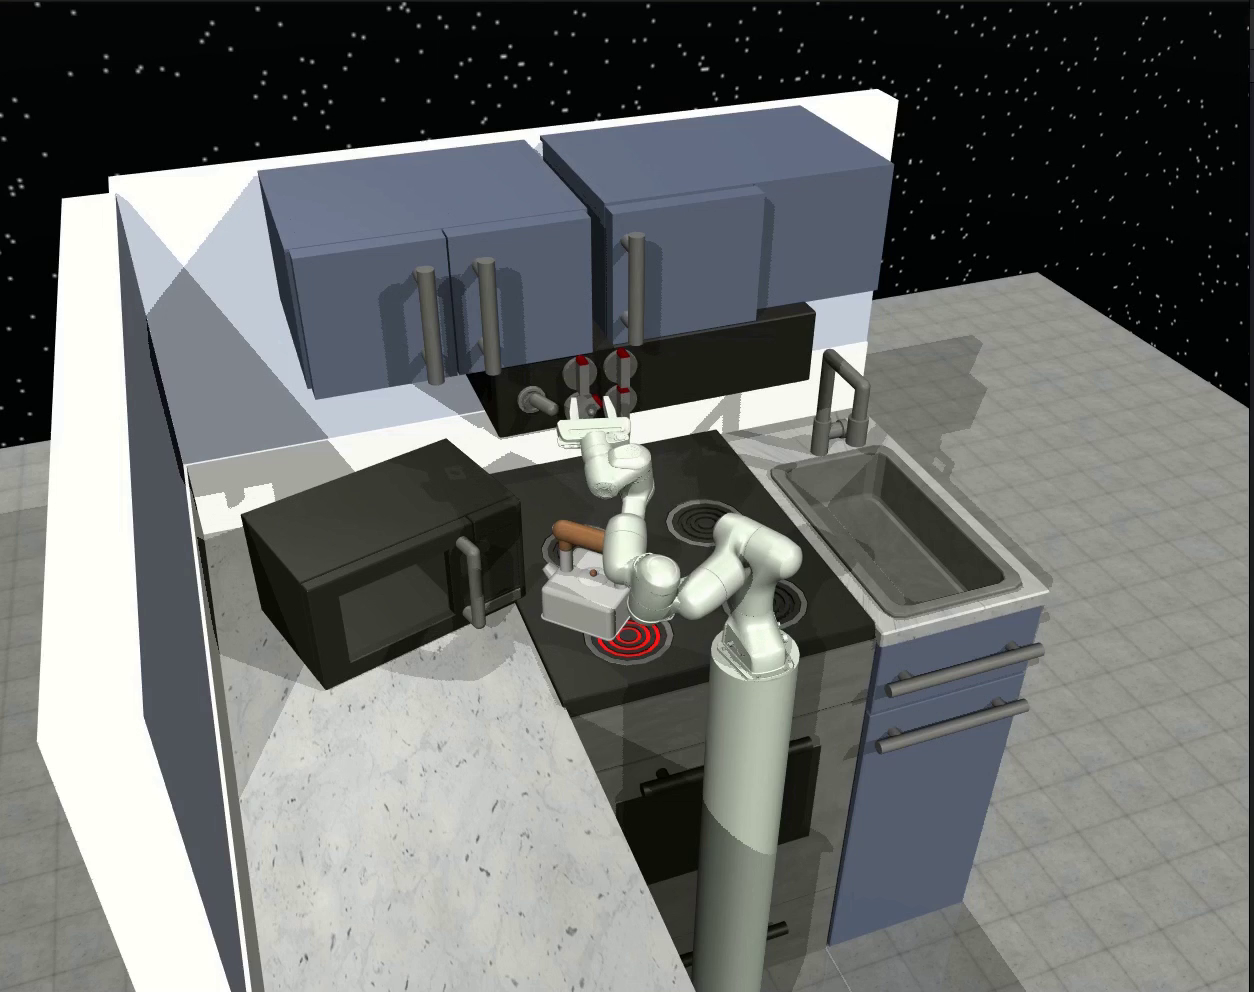

In [145]:
all_frames[2][90]